In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from utils.seq_data_loader import LoanSimDataset, collate_fn
from torch.utils.data import DataLoader
import numpy as np

In [2]:
# Device setup
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
scale_columns = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
]

features = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
]

# Section 1: Prediction of the Recovery Rate

In [4]:
recovery_targets = [
    # "y_installment",
    # "y_installment_timestep",
    # "y_state_cum_overduelength",
    # "y_remaining_debt",
    # "y_state_capital",
    # "y_state_interests",
    # "y_state_penalty",
    # "installment_done",
    # "loan_done",
    "recovery_rate_weighted",
]

In [5]:
recovery_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=recovery_targets,
    group="train",
)


# use the test data as validation data
recovery_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=recovery_targets,
    group="test",  # read the test data
)

recovery_train_dataloader = DataLoader(
    recovery_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


recovery_val_dataloader = DataLoader(
    recovery_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [6]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(recovery_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100

# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [7]:
from torch import optim
from models.lstm_recovery_1 import LSTMModel as LSTMModel1

model = LSTMModel1(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)


criterion = nn.MSELoss()  # regression question, so use MSE as the Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model.to(device)
recovery_train_losses = []
recovery_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in recovery_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    recovery_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(recovery_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in recovery_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    recovery_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(recovery_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # save the best model
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.00243418, Val Loss: 0.00212868
Epoch 2/100, Train Loss: 0.00201164, Val Loss: 0.00200023
Epoch 3/100, Train Loss: 0.00190133, Val Loss: 0.00189349
Epoch 4/100, Train Loss: 0.00185731, Val Loss: 0.00184577
Epoch 5/100, Train Loss: 0.00181274, Val Loss: 0.00183630
Epoch 6/100, Train Loss: 0.00181047, Val Loss: 0.00182597
Epoch 7/100, Train Loss: 0.00177606, Val Loss: 0.00183148
Epoch 8/100, Train Loss: 0.00176231, Val Loss: 0.00181335
Epoch 9/100, Train Loss: 0.00175163, Val Loss: 0.00181424
Epoch 10/100, Train Loss: 0.00175955, Val Loss: 0.00177039
Epoch 11/100, Train Loss: 0.00172446, Val Loss: 0.00178056
Epoch 12/100, Train Loss: 0.00172017, Val Loss: 0.00180696
Epoch 13/100, Train Loss: 0.00169967, Val Loss: 0.00178421
Epoch 14/100, Train Loss: 0.00169846, Val Loss: 0.00179146
Epoch 15/100, Train Loss: 0.00170004, Val Loss: 0.00178772
Epoch 16/100, Train Loss: 0.00168344, Val Loss: 0.00174603
Epoch 17/100, Train Loss: 0.00170810, Val Loss: 0.00177661
Epoch 

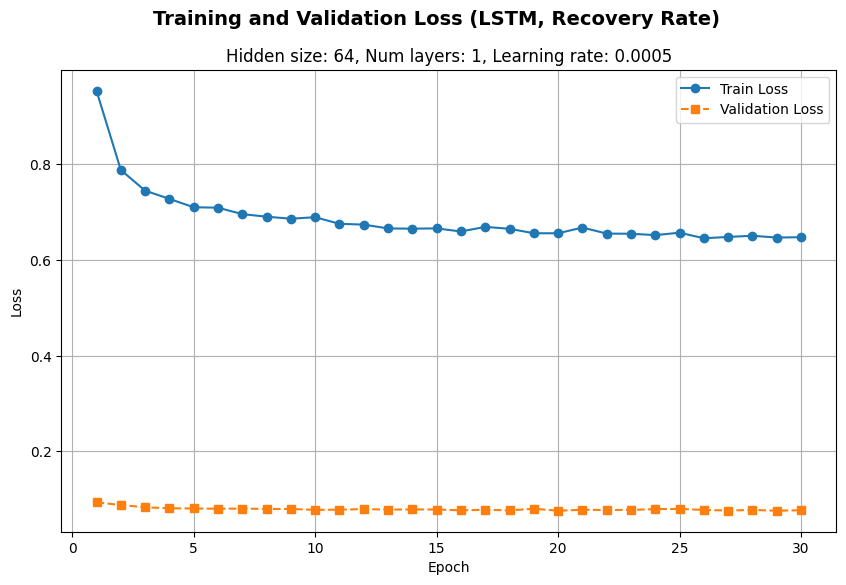

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, len(recovery_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, recovery_train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, recovery_val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Recovery Rate)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

# Section 2: Prediction of the Next State

In [10]:
state_targets = [
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
    # "installment_done",
    # "loan_done",
    # "recovery_rate_weighted",
]

In [16]:
state_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=state_targets,
    group="train",
)


# use the test data as validation data
state_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=state_targets,
    group="test",  # read the test data
)

state_train_dataloader = DataLoader(
    state_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


state_val_dataloader = DataLoader(
    state_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [18]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(state_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100
# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [19]:
from models.lstm_state_1 import LSTMModel as LSTMModel2


model = LSTMModel2(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)


criterion = nn.MSELoss()  # regression question, so use MSE as the Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
model.to(device)


state_train_losses = []
state_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in state_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    state_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(state_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in state_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    state_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(state_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # torch.save(model.state_dict(), "best_model.pth")  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.22386536, Val Loss: 0.13820779
Epoch 2/100, Train Loss: 0.10411106, Val Loss: 0.07332563
Epoch 3/100, Train Loss: 0.06528625, Val Loss: 0.05507995
Epoch 4/100, Train Loss: 0.05142121, Val Loss: 0.04517970
Epoch 5/100, Train Loss: 0.04483295, Val Loss: 0.04027799
Epoch 6/100, Train Loss: 0.04092727, Val Loss: 0.03823591
Epoch 7/100, Train Loss: 0.03827134, Val Loss: 0.03592146
Epoch 8/100, Train Loss: 0.03664301, Val Loss: 0.03447580
Epoch 9/100, Train Loss: 0.03483481, Val Loss: 0.03378096
Epoch 10/100, Train Loss: 0.03422964, Val Loss: 0.03282692
Epoch 11/100, Train Loss: 0.03327326, Val Loss: 0.03190752
Epoch 12/100, Train Loss: 0.03276056, Val Loss: 0.03197225
Epoch 13/100, Train Loss: 0.03206891, Val Loss: 0.03131737
Epoch 14/100, Train Loss: 0.03176321, Val Loss: 0.03141426
Epoch 15/100, Train Loss: 0.03123900, Val Loss: 0.03032280
Epoch 16/100, Train Loss: 0.03114405, Val Loss: 0.03054606
Epoch 17/100, Train Loss: 0.03104622, Val Loss: 0.03020463
Epoch 

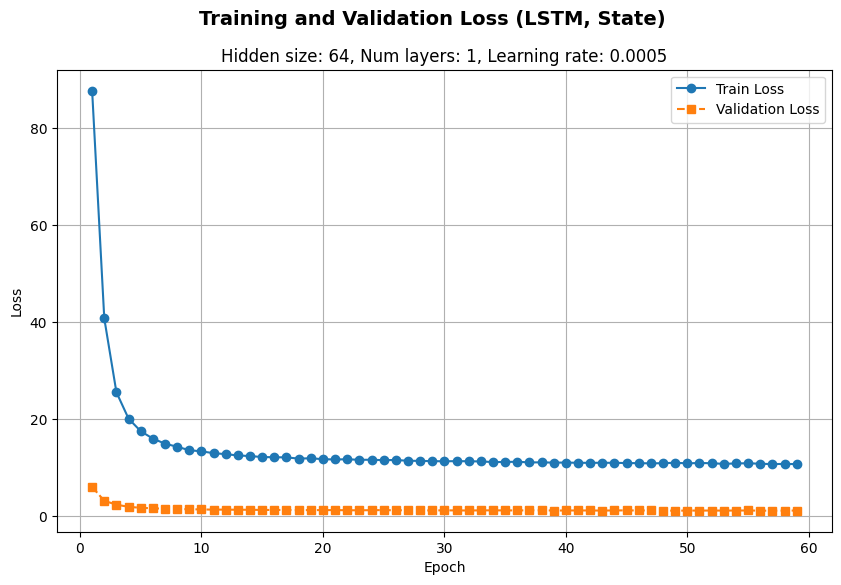

In [21]:
epochs = range(1, len(state_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, state_train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, state_val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, State)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()